In [2]:
from Utils.Methods import *
import os
import platform
from datetime import *
import sys
import warnings
import psutil
import traceback
import csv
import math
import shutil 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.libqsturng import qsturng, psturng
import numpy as np
import numpy_indexed as npi
import pandas as pd
from pyopenms import *
from datetime import *
import pandas as pd
import pingouin as pg
from hypothetical.descriptive import var
from scipy import stats, signal
from scipy.stats import zscore, t
from scipy.optimize import curve_fit
from scipy.integrate import quad, cumulative_trapezoid
from scipy.signal import find_peaks, peak_widths, welch, savgol_filter
from scipy.ndimage import gaussian_filter1d
import scikit_posthocs as sp
from itertools import combinations
import peakutils

## Inputs

In [3]:
prots = ['12ca5-Alq6','MDM2-Alq6']   # List of proteins in selection
prots.sort()                                             # Alphabetizes all of the proteins for ease
selection = '284-188 pyBinder 12ca5 vs MDM2 Aliq 6'       
# Name of selection, will be in folder name                                                             # E = Eclipse, L= Lumos, UT = Untargeted, T = Targeted
enr_score_cutoff = 1/len(prots)                                                     # cutoff score for sequencing run
p_score_cutoff = 0.15
show_EICs = False
nr_EICs = 100
peak_RT = 300                                 # width (in seconds) of peak, used for max intensity search, gets divided by 2 for +-
peps_sec = 3                    # maximum amount of peptides that can coelute, for building inclusion list
n_reps = 3
lib_size = 13
conc_lib_start = 10    # pM/member
PRTC_conc = 2*1000     # pM/member
    
TIME = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")                   # Gets current time to prevent duplicate folders        
parent_dir = r'E:\Lumos_Data\20220928 - 284-188 12ca5 vs MDM2 pyBinder'
folder = selection + ' ' + TIME                                        # Name of new folder to save output
data_dir = os.path.join(parent_dir,folder)                               # New folder to store centroided data
save_dir = os.path.join(parent_dir,folder)                               # If data is already centroided, use this folder 
                                                                         #    to save useful output
default_thresh = 5E4                                                     # Threshold of peak detection (ion counts)
LOD = 1.5e4                                                              # Number of replicates per protein
centroided = True                                                       # Will skip the centroiding step if True
check_data = False                                                        # Will skip the TIC and 2D plotting if False, prints out TIC otherwise
full_out = True                                                          # Will print all features found for each protein
known_binders = False                                                    # Do you have a formatted csv of known binders to find (for diagnostics)
PRTC_check = True

do_second_filter = True
do_EICs = True                                                           # True to activate EICs, take majority of runtime
do_subtract = False                                                      # Will subtract background from intensity for scoring
use_savgol = True
use_fft = False

C:\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Directory and reference setup

In [4]:
sys_checks(parent_dir,prots,centroided,enr_score_cutoff,p_score_cutoff,peak_RT,peps_sec,n_reps,nr_EICs,LOD,True)
eic_dirs,eic_dirs_spec,eic_dirs_nonspec,eic_dirs_other,png_dir,PRTC_dir = directory_setup(parent_dir,folder,save_dir,prots,centroided)

if PRTC_check:
    PRTC_masses = [900.5524,985.5220,1114.6374,1171.5861,1224.619,1488.7704]
    PRTC_rts = [8.7*60,6.5*60,13.6*60,11.3*60,7.5*60,13.7*60]
    PRTC_mass_round = np.round(PRTC_masses,2)

RAW files found to analyze: ['284-188-12ca5-Alq6-Repl1-Scout-1.raw', '284-188-12ca5-Alq6-Repl1-Scout-2.raw', '284-188-12ca5-Alq6-Repl1-Scout-3.raw', '284-188-MDM2-Alq6-Repl1-Scout-1.raw', '284-188-MDM2-Alq6-Repl1-Scout-2.raw', '284-188-MDM2-Alq6-Repl1-Scout-3.raw']


## Data centroiding and checks

In [ ]:
data_dir = data_centroiding(centroided,parent_dir,folder,PRTC_dir,data_dir)
data_visualization(check_data,data_dir,png_dir,parent_dir)

## Feature Finding

In [1]:
column_names = []
feature_maps = []
files = []
files_full = []
# paper on feature finder: https://doi.org/10.1021/pr300992u

for file in sorted(os.listdir(data_dir)):
    if file.endswith('.mzML'):
        print(file)
        if not 'PRTC' in file:
            files.append(file[:-5])
            files_full.append(file)
        exp = MSExperiment()
        out = FeatureXMLFile()
        MzMLFile().load(os.path.join(data_dir,file),exp)
        exp.updateRanges()
        
        feature_finder = FeatureFinder()       
        # Get and set parameters 
        params = feature_finder.getParameters('centroided')
        params.setValue('mass_trace:mz_tolerance',0.004) # default 0.004, old opt 0.004
        params.setValue('isotopic_pattern:mz_tolerance',0.010) # default 0.005, old opt 0.010
        params.setValue('isotopic_pattern:charge_low',2)
        params.setValue('isotopic_pattern:charge_high',5)
        params.setValue('feature:max_rt_span',3.0) # default 2.5 - try 1.5,2,3 - done, old opt 3.0
        params.setValue('mass_trace:min_spectra',9) # default 10, try 9,8,7,6,5 - done, old opt 9 - 7 did nothing
        params.setValue('feature:rt_shape', 'asymmetric')  # default symmetric - done, old opt asymmetric
        params.setValue('seed:min_score',0.5)  # default 0.8, try 0.5,0.6,0.7 - done, old opt 0.5
        params.setValue('feature:min_score',0.5) # default 0.7, try 0.6, 0.5 - done, old opt 0.5
        params.setValue('mass_trace:max_missing',4)   # 1 is default, try 2,3,4,5 gave no features - done, old opt 4
        print(params.items())
    
        # Run feature finder and store as featureXML and in array
        if 'PRTC' in file:
            PRTC_feature_map = FeatureMap()
            feature_finder.run('centroided', exp, PRTC_feature_map, params, FeatureMap())
            PRTC_feature_map.setPrimaryMSRunPath([str.encode(file[:-5])])
            fXML = FeatureXMLFile()
            file_name = file[:-5] + '.featureXML'
            fXML.store(os.path.join(PRTC_dir,file_name),PRTC_feature_map)
        else:
            feature_map = FeatureMap()
            feature_finder.run('centroided', exp, feature_map, params, FeatureMap())
            feature_map.setPrimaryMSRunPath([str.encode(file[:-5])])
            feature_maps.append(feature_map)
            fXML = FeatureXMLFile()
            file_name = file[:-5] + '.featureXML'
            fXML.store(os.path.join(save_dir,file_name),feature_map)
        print('feature map done')
        print(' ')

NameError: name 'os' is not defined

## Feature alignment and grouping

In [ ]:
# Use replicate with most features as reference
ref_index = [i[0] for i in sorted(enumerate([fm.size() for fm in feature_maps]), key=lambda x: x[1])][-1]
ref_RTs = [f.getRT() for f in feature_maps[ref_index]]
aligner = MapAlignmentAlgorithmPoseClustering()
aligner.setReference(feature_maps[ref_index])
align_params = aligner.getParameters()
align_params.setValue('superimposer:mz_pair_max_distance', 0.5) 
align_params.setValue('pairfinder:distance_RT:max_difference',300.00)
align_params.setValue('superimposer:max_shift',2000.0)
aligner.setParameters(align_params)

for feature_map in feature_maps[:ref_index] + feature_maps[ref_index + 1:]:
    trafo = TransformationDescription()
    aligner.align(feature_map, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(feature_map, trafo, True)  # store original RT as meta value

new_RTs_list = []
original_RTs_dict = {}

for i,fm in enumerate(feature_maps):
    if i == ref_index:
        original_RTs_dict[i] = ref_RTs
    else:
        original_RT = [f.getMetaValue('original_RT') for f in fm]
        original_RTs_dict[i] = original_RT

alignment_dict = {}  # contains matrices of form [original_RT, aligned_RT]
for i,dic in enumerate(original_RTs_dict.values()):
    feature_map = feature_maps[i]
    RTs_array = []
    for j,RT_orig in enumerate(dic):
        pair = [RT_orig,feature_map[j].getRT()]
        RTs_array.append(pair)
    alignment_dict[i] = RTs_array

In [ ]:
# Paper on feature grouper: https://doi.org/10.1021/pr300992u

feature_grouper = FeatureGroupingAlgorithmQT()  # Uses a quality threshold feature grouper
grouper_params = feature_grouper.getParameters()
grouper_params.setValue('distance_MZ:max_difference',0.01)
grouper_params.setValue('distance_RT:max_difference',150.0)
feature_grouper.setParameters(grouper_params)

consensus_map = ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = feature_map.getMetaValue('spectra_data')[0].decode()
    file_description.size = feature_map.size()
    file_description.unique_id = feature_map.getUniqueId()
    file_descriptions[i] = file_description
    
consensus_map.setColumnHeaders(file_descriptions)
feature_grouper.group(feature_maps, consensus_map)

ConsensusXMLFile().store(os.path.join(save_dir,'consensusmap.consensusXML'),consensus_map)

In [ ]:
if PRTC_check:
    PRTC_features_mz = []
    PRTC_features_RT = []
    for f in PRTC_feature_map:
        obs_mass = (f.getMZ()*f.getCharge())-1.0074*f.getCharge()
        if np.round(obs_mass,2) in PRTC_mass_round and f.getCharge() == 2:
            PRTC_features_mz.append(f.getMZ())
            PRTC_features_RT.append(f.getRT())

In [ ]:
con_feat = []               
for cf in consensus_map:
    RT_cf = cf.getRT()
    Qual_cf = cf.getQuality()
    Charge_cf = cf.getCharge()
    MZ_cf = cf.getMZ()
    con_feat.append([cf.getRT(),cf.getCharge(),cf.getMZ(),cf.getQuality()])
    
map_idxs = []
map_RTs = []

for cf in consensus_map:
    map_idx = []
    map_RT = []
    for f in cf.getFeatureList():
        map_idx.append(f.getMapIndex())
        map_RT.append(f.getRT())
    map_idxs.append(map_idx)
    map_RTs.append(map_RT)

new_map_idxs = []
new_map_RTs = []   # these are the RTs from each feature map post-alignment

for i in range(len(map_RTs)):
    feat_idxs = map_idxs[i]
    feat_RTs = map_RTs[i]
    new_map_idx = []
    new_map_RT = []
    for i in range(len(feature_maps)):
        new_map_idx.append(i)
        if i in feat_idxs:
            RT = feat_RTs[feat_idxs.index(i)]
            new_map_RT.append(RT)
        if i not in feat_idxs:
            new_map_RT.append(0)   # this is where the problem is - if feature not in replicate, puts 0 for RT
    new_map_idxs.append(new_map_idx)
    new_map_RTs.append(new_map_RT)

### Alignment checks, original RT extraction

In [ ]:
fixed_RT_maps_formatted = alignment_check(consensus_map,feature_maps,png_dir,new_map_RTs,files,original_RTs_dict)

In [ ]:
col_names = []
for fm in feature_maps:
    col_names.append(fm.getMetaValue('spectra_data')[0].decode())

cf_df_1 = pd.DataFrame(con_feat,columns=['RT consensus','charge','m/z','quality'])
cf_df_3 = pd.DataFrame(fixed_RT_maps_formatted,columns=col_names)
cf_df_2 = pd.DataFrame(new_map_RTs,columns=col_names)

cf_df_final = pd.concat([cf_df_1,cf_df_2,cf_df_3],axis=1)
cf_df_final_np = cf_df_final.to_numpy()

cf_df_final.to_csv(os.path.join(parent_dir,folder,'Consensus Features.csv'),index=False)

feat_RT_cf_combined = []
feat_mz_combined = []
feat_z_combined = []
feat_quality_combined = []
feat_obs_mass_combined = []
RTs = []

for entry in cf_df_final_np:
    feat_RT_cf_combined.append(entry[0])
    feat_mz_combined.append(entry[2])
    feat_z_combined.append(entry[1])
    feat_obs_mass_combined.append(entry[2]*entry[1]-entry[1]*1.0074)
    feat_quality_combined.append(entry[3])
    RTs.append(entry[4:])
    
print(len(feat_mz_combined))
    
feat_RT_cf_combined_massfiltered = []
feat_RT_orig_massfiltered = []
feat_mz_combined_massfiltered = []
feat_z_combined_massfiltered = []
feat_quality_combined_massfiltered = []
feat_obs_mass_combined_massfiltered = []
RTs_massfiltered = []

ref_feature_mass = []
ref_feature_RT = []
ref_feature_RT_orig = []
refs_found = []

for i,obs_mass in enumerate(feat_obs_mass_combined):
    entry = cf_df_final_np[i]
    if PRTC_check and np.round(obs_mass,2) in PRTC_mass_round and entry[1] == 2:
        ref_feature_mass.append(entry[2])
        ref_feature_RT.append(entry[0])
        ref_feature_RT_orig.append(fixed_RT_maps_formatted[i])
        refs_found.append(np.round(obs_mass,2))
    elif obs_mass > 57.021*lib_size + 17.98:   # assuming we have a peptide of the correct length of only glycines
        feat_RT_cf_combined_massfiltered.append(entry[0])
        feat_RT_orig_massfiltered.append(fixed_RT_maps_formatted[i])
        feat_mz_combined_massfiltered.append(entry[2])
        feat_z_combined_massfiltered.append(entry[1])
        feat_obs_mass_combined_massfiltered.append(entry[2]*entry[1]-entry[1]*1.0074)
        feat_quality_combined_massfiltered.append(entry[3])
        RTs_massfiltered.append(entry[4:])
    
if PRTC_check:
    for mass in PRTC_mass_round:
        if mass not in refs_found:
            warnings.warn(f"Warning: PRTC reference mass {mass} not found in consensus features!")
print(len(feat_mz_combined_massfiltered))

C:\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
mzs_list,RTs_list,ints_list = get_data(data_dir)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:\\Lumos_Data\\20220928 - 284-188 12ca5 vs MDM2 pyBinder\\284-188 pyBinder 12ca5 vs MDM2 Aliq 6 2022_10_12-03_46_23_PM'

In [5]:
### Get PRTC peptide areas from initial reference
if PRTC_check:
    mzs_ref,RTs_ref,ints_ref = get_data(PRTC_dir)
    _,rt_windows_start,int_windows_start,_ = feature_int_extractor_start(PRTC_features_mz,PRTC_features_RT,mzs_ref,RTs_ref,ints_ref,LOD=1.5E4,noise_level=1.5e4,peak_range=peak_RT)
    areas_PRTC = [val[0] for val in feature_area_extractor_savgol(rt_windows_start,int_windows_start)]

    PRTCs_found_start = np.unique(np.round(PRTC_features_mz,1))
    PRTC_area_ref = {}
    for mass in PRTCs_found_start:
        idxs = np.where(np.round(PRTC_features_mz,1) == mass)[0]
        area_ion = np.average([np.average(entry) for entry in [areas_PRTC[j] for j in idxs if areas_PRTC[j] > 1]])
        PRTC_area_ref[mass] = area_ion

NameError: name 'PRTC_dir' is not defined

In [15]:
if PRTC_check:
    ### Get PRTC peptide areas within replicates
    ints_ref,rt_windows_ref,int_windows_ref,backs_ref = feature_int_extractor(ref_feature_mass,ref_feature_RT,ref_feature_RT_orig,mzs_list,RTs_list,ints_list,LOD=1.5E4,noise_level=1.5e4,peak_range=peak_RT)
    areas_ref_full = feature_area_extractor_savgol(rt_windows_ref,int_windows_ref)
    areas_ref_average = [np.average(entry) for entry in areas_ref_full]
    area_ref = np.average(areas_ref_average)*conc_lib_start/PRTC_conc

In [16]:
if PRTC_check:
    PRTC_stats(areas_ref_full,files,ref_feature_mass,png_dir)

    PRTCs_found = np.unique(np.round(ref_feature_mass,1))
    PRTC_area_reps = {}
    for mass in PRTCs_found:
        idxs = np.where(np.round(ref_feature_mass,1) == mass)[0]
        area_average_ion = np.average([np.average(entry) for entry in [[area for area in areas_ref_full[j] if area > 1] for j in idxs]])
        PRTC_area_reps[mass] = area_average_ion

In [17]:
max_ints,rt_windows, int_windows, backgrounds = feature_int_extractor(feat_mz_combined_massfiltered,feat_RT_cf_combined_massfiltered,feat_RT_orig_massfiltered,mzs_list,RTs_list,ints_list,LOD=1.5E4,noise_level=1.5E4,peak_range=peak_RT)

0
1000
2000
3000
4000
5000
6000
7000
8000


In [18]:
if use_savgol:
    peak_regular = peak_finder_savgol(rt_windows,int_windows,prots,plot=False,default_thresh=default_thresh,kernal_size=3,width=5,rel_height=0.5,reps=n_reps)
    peak_filtered = []
    feat_mz_filtered = []
    feat_RT_filtered = []
    feat_RT_orig_filtered = []
    feat_z_filtered = []
    check_rt_windows = []
    check_int_windows = []
    max_ints_filtered = []
    for i,peak_group in enumerate(peak_regular):
        test = np.concatenate(peak_group)
        if np.any(test):
            peak_filtered.append(peak_group)
            feat_mz_filtered.append(feat_mz_combined_massfiltered[i])
            feat_RT_filtered.append(feat_RT_cf_combined_massfiltered[i])
            feat_RT_orig_filtered.append(feat_RT_orig_massfiltered[i])
            check_rt_windows.append(rt_windows[i])
            check_int_windows.append(int_windows[i])
            feat_z_filtered.append(feat_z_combined_massfiltered[i])
            max_ints_filtered.append(max_ints[i])

    print(f'Features removed: {len(feat_mz_combined_massfiltered) - len(feat_mz_filtered)}')
    print(f'Features remaining: {len(feat_mz_filtered)}')

0
1000
2000
3000
4000
5000
6000
7000
8000
Features removed: 4667
Features remaining: 3761


In [19]:
areas_savgol = feature_area_extractor_savgol(check_rt_windows,check_int_windows,check=False,width_start=10,prominence=2,threshold=10,rel_height=0.85)

0
1000
2000
3000


In [20]:
if not PRTC_check:
    area_ref = 1
    
enrichmentscores,enrichment_normalized,pvals,specifics,spec_label = enr_scoring(areas_savgol,area_ref,prots,prots,reps=n_reps,p_score_cutoff=p_score_cutoff)

Moving on to stats


/home/gridsan/mlee/.local/lib/python3.8/site-packages/pingouin/parametric.py:1292: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.mean()).sum() / weights.sum()
/home/gridsan/mlee/.local/lib/python3.8/site-packages/pingouin/parametric.py:1292: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.mean()).sum() / weights.sum()
/home/gridsan/mlee/.local/lib/python3.8/site-packages/pingouin/parametric.py:1292: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.mean()).sum() / weights.sum()
/home/gridsan/mlee/.local/lib/python3.8/site-packages/pingouin/parametric.py:1292: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.mean()).sum() / weights.sum()


Moving on to scoring


In [21]:
if not do_second_filter:
    feat_mz_filtered = feat_mz_combined_massfiltered
    feat_RT_filtered = feat_RT_cf_combined_massfiltered
    feat_z_filtered = feat_z_combined_massfiltered
    max_ints_filtered = max_ints

## Outputs

In [22]:
es_graphing,es_normalized_graphing,ps_graphing,RTs_graphing,RTs_graphing_orig,mzs_graphing,z_graphing,areas_graphing,es_nonspecific,es_normalized_nonspecific,ps_nonspecific,RTs_nonspecific,RTs_nonspecific_orig, \
    mzs_nonspecific,z_nonspecific,areas_nonspecific, es_unclear,es_normalized_unclear,ps_unclear,RTs_unclear,RTs_unclear_orig,mzs_unclear,z_unclear,areas_unclear = setup_output(prots,spec_label,enrichmentscores,enrichment_normalized,pvals,feat_RT_filtered,feat_RT_orig_filtered,feat_mz_filtered,feat_z_filtered,areas_savgol)

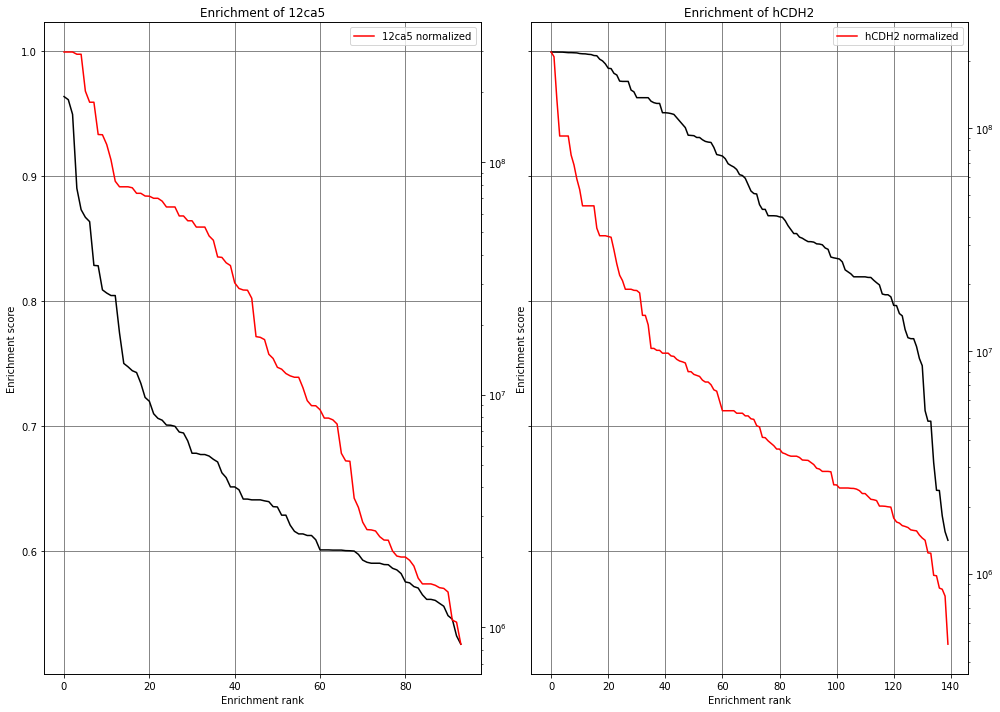

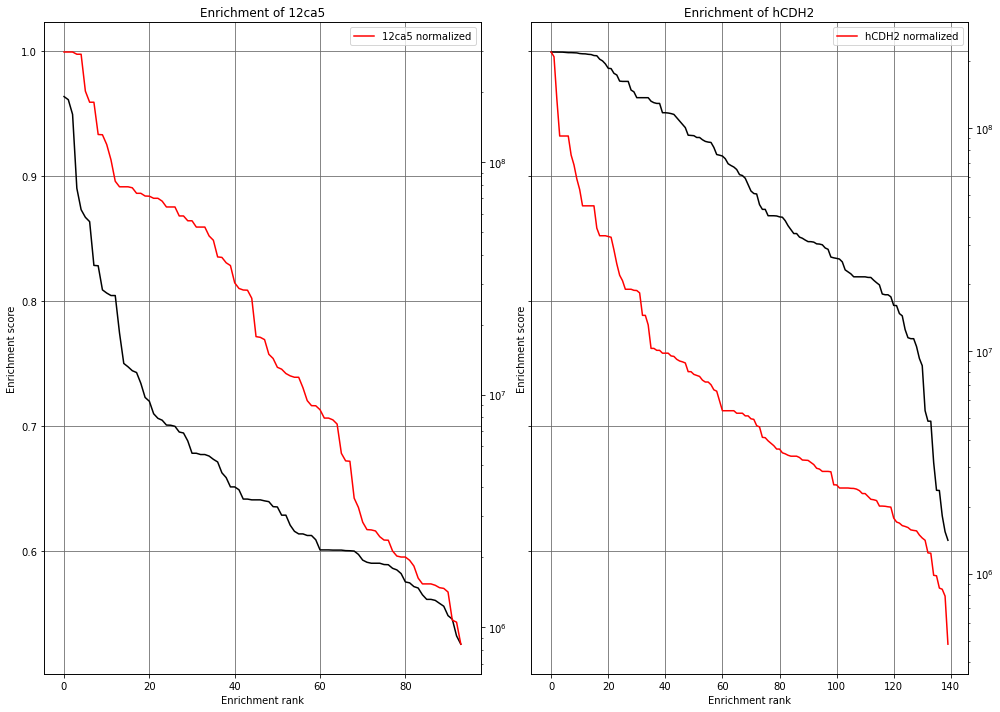

In [23]:
enrichment_rankings(prots,es_graphing,es_normalized_graphing,png_dir)

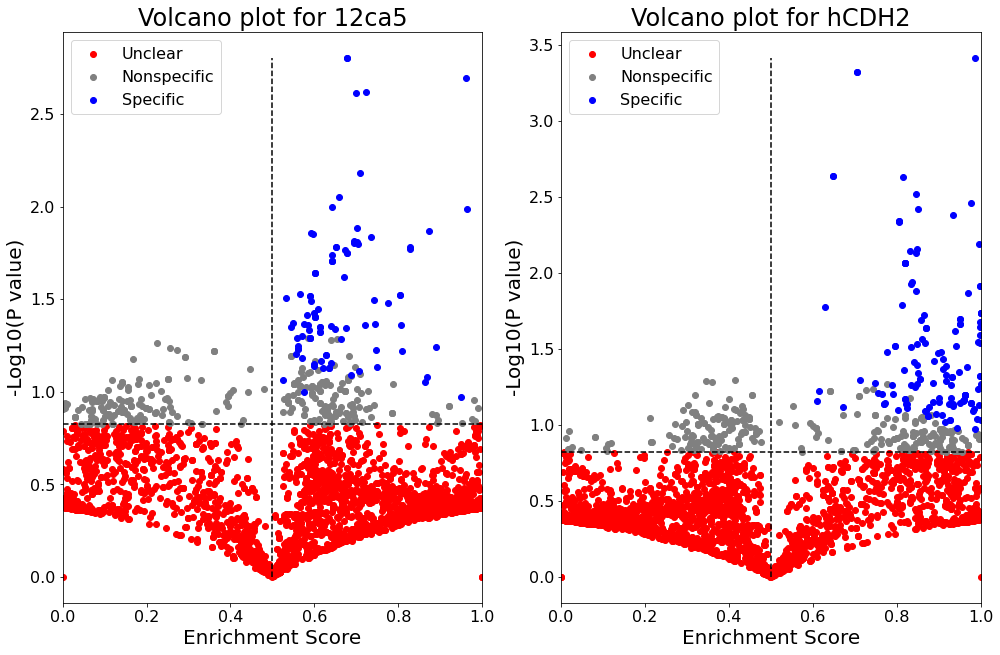

In [24]:
volcano_plotting(prots,es_graphing,es_nonspecific,es_unclear,ps_graphing,ps_nonspecific,ps_unclear,feat_mz_combined,enrichmentscores,p_score_cutoff,enr_score_cutoff,save_dir)

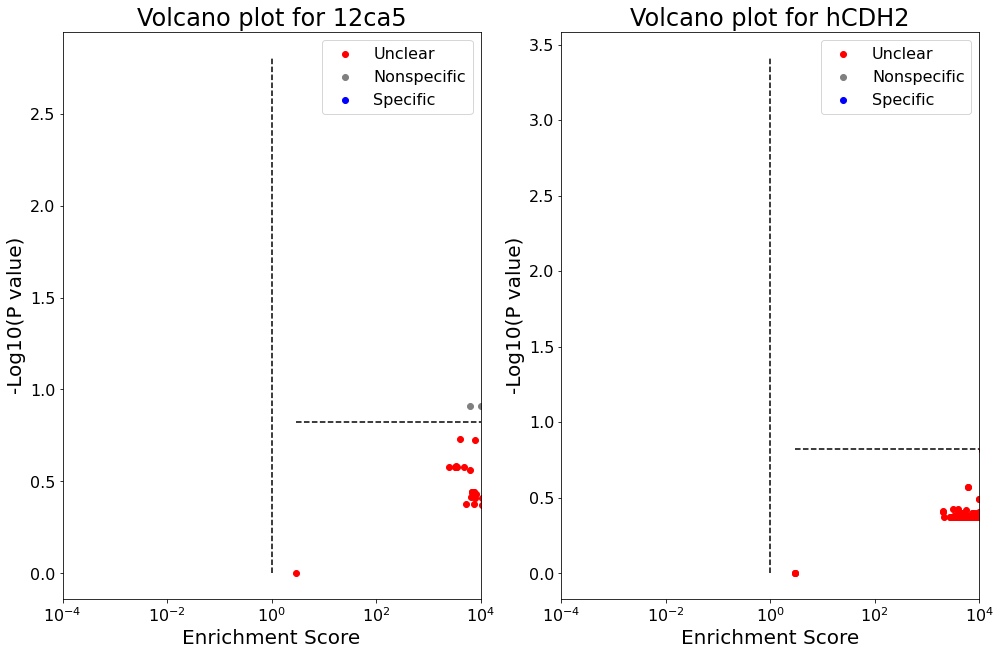

In [25]:
volcano_plots_normalized(prots,es_normalized_graphing,es_normalized_nonspecific,es_normalized_unclear,ps_graphing,ps_nonspecific,ps_unclear,p_score_cutoff,enr_score_cutoff,save_dir)

In [26]:
export_results(enrichmentscores,es_graphing,RTs_graphing,mzs_graphing,ps_graphing,z_graphing,enr_score_cutoff,
               p_score_cutoff,prots,parent_dir,folder,feat_RT_cf_combined,feat_mz_filtered,
               feat_z_filtered,pvals,spec_label,areas_savgol,full_out)

In [27]:
compare_known_binders(known_binders,prots,parent_dir,folder,feat_mz_combined_massfiltered,feat_mz_combined,feat_RT_cf_combined)

### EICs

In [28]:
if do_EICs:
    if PRTC_check:
        plot_PRTC(ref_feature_mass,ref_feature_RT,ref_feature_RT_orig,areas_ref_full,data_dir,PRTC_dir,baseline=0,peak_range=peak_RT,show_plot=show_EICs,reps=n_reps)
    
    for i,score in enumerate(es_graphing):
        score_sorted = np.sort(score)[::-1]
        indices_sorted = np.argsort(score)[::-1]
        count = 0
        mzs = []
        RTs = []
        RTs_orig = []
        scores = []
        p_to_graph = []
        areas_to_graph = []
        while score_sorted[count] >= enr_score_cutoff and len(scores) < nr_EICs:
            index = indices_sorted[count]
            mzs.append(mzs_graphing[i][index])
            RTs.append(RTs_graphing[i][index])
            RTs_orig.append(RTs_graphing_orig[i][index])
            scores.append(score_sorted[count])
            p_to_graph.append(ps_graphing[i][index][0])
            areas_to_graph.append(areas_graphing[i][index])
            count -= -1
            if count >= len(score):
                break
        print(' ')
        specific = plot_EIC(mzs,RTs,RTs_orig,scores,p_to_graph,areas_to_graph,data_dir,eic_dirs_spec[i],baseline=0,peak_range=peak_RT,show_plot=show_EICs,reps=n_reps)
    if es_nonspecific:
        for i in range(len(prots)):
            score = [entry[i] for entry in es_nonspecific]
            score_sorted = np.sort(score)[::-1]
            indices_sorted = np.argsort(score)[::-1]
            count = 0
            mzs = []
            RTs = []
            RTs_orig = []
            scores = []
            p_to_graph = []
            areas_to_graph = []
            while score_sorted[count] >= enr_score_cutoff and len(scores) < nr_EICs:
                index = indices_sorted[count]
                mzs.append(mzs_nonspecific[index])
                RTs.append(RTs_nonspecific[index])
                RTs_orig.append(RTs_nonspecific_orig[index])
                scores.append(score_sorted[count])
                p_to_graph.append(ps_nonspecific[index][0])
                areas_to_graph.append(areas_nonspecific[index])
                count -= -1
                if count >= len(score):
                    break
            print(' ')
            nonspecific = plot_EIC(mzs,RTs,RTs_orig,scores,p_to_graph,areas_to_graph,data_dir,eic_dirs_nonspec[i],baseline=0,peak_range=peak_RT,show_plot=show_EICs,reps=n_reps)
    for i in range(len(prots)):
        score = [entry[i] for entry in es_unclear]
        score_sorted = np.sort(score)[::-1]
        indices_sorted = np.argsort(score)[::-1]
        count = 0
        mzs = []
        RTs = []
        RTs_orig = []
        scores = []
        p_to_graph = []
        areas_to_graph = []
        while len(scores) < nr_EICs:
            index = indices_sorted[count]
            mzs.append(mzs_unclear[index])
            RTs.append(RTs_unclear[index])
            RTs_orig.append(RTs_unclear_orig[index])
            scores.append(score_sorted[count])
            p_to_graph.append(ps_unclear[index][0])
            areas_to_graph.append(areas_unclear[index])
            count -= -1
            if count >= len(score):
                break
        print(' ')
        unclear = plot_EIC(mzs,RTs,RTs_orig,scores,p_to_graph,areas_to_graph,data_dir,eic_dirs_other[i],baseline=0,peak_range=peak_RT,show_plot=show_EICs,reps=n_reps)